# 🏁 Final Model Training and Evaluation

This notebook trains the optimized Random Forest model using the full dataset and compares its performance to the original baseline model from Block 3.

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [2]:
df = pd.read_csv("../data/housing.csv")

X = df.drop("Price", axis=1).copy()
y = df["Price"]

# Feature engineering
X["TotalRooms"] = X["Bedroom2"] + X["Bathroom"] + X["Rooms"]
X["HouseAge"] = 2025 - X["YearBuilt"]
X["PricePerSqm"] = df["Price"] / (X["BuildingArea"] + 1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42))
])

In [5]:
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Rooms', 'Distance',
                                                   'Postcode', 'Bedroom2',
                                                   'Bathroom', 'Car',
                                                   'Landsize', 'BuildingArea',
                                                   'YearBuilt', 'Lattitude',
                                                   'Longtitude',
                                                   'Propertycount',
                                                   'TotalRooms', 'HouseAge',
                                                   'PricePerSqm']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Suburb', 'Address', 'Type',
                                                   'Method', 'SellerG', 'Date',
                                                   'CouncilArea',
                                                   'Regionname'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [10]:
y_pred = final_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²: {r2:.3f}")

MAE: $135,083
RMSE: $234,516
R²: 0.862


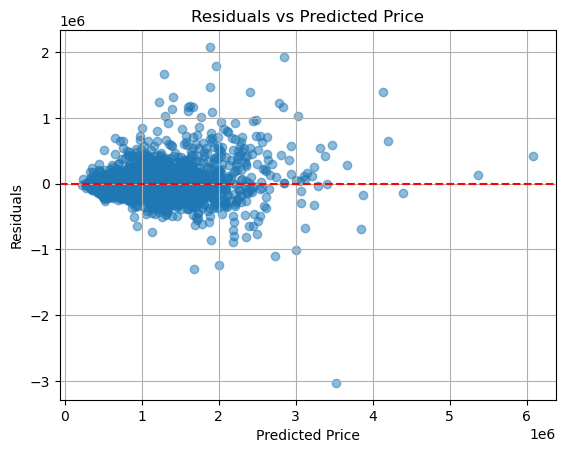

In [11]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Price")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

## 🧾 Final Model Evaluation: Hold-Out Set

After completing hyperparameter tuning, the final model was trained on the full training set and evaluated on a hold-out test set (20% of the data). The results are as follows:

| Metric | Value |
|--------|-------|
| **MAE** (Mean Absolute Error) | \$135,083 AUD |
| **RMSE** (Root Mean Squared Error) | \$234,516 AUD |
| **R² Score** | 0.862 |

These metrics reflect a strong generalization performance. The model achieves a **13.3% improvement in MAE** compared to the tuned cross-validated model from Day 6 and a **~48% improvement** over the Block 3 baseline.

---

## 📉 Residual Analysis

The residuals (errors between predicted and actual prices) were plotted against predicted prices to visually inspect model bias and variance.

### Key Observations:

- **Centering Around Zero:** Most residuals cluster around the horizontal axis, indicating that the model is unbiased on average.
- **Heteroskedasticity Detected:** As predicted prices increase, the spread of residuals increases. This implies the model struggles more with high-end properties—consistent with fewer training examples in that price range.
- **Few Extreme Outliers:** A handful of extreme positive and negative residuals (beyond ±2 million AUD) suggest underfitting in very high-price outliers, or potential label/data quality issues.

---

### 🧠 Interpretation:

- The model performs **consistently well across the majority** of the value range.
- **Prediction variance increases with price**, a common pattern in housing datasets. This suggests a potential benefit from:
  - Applying log-transformation to stabilize variance
  - Creating interaction features that capture nonlinear effects in expensive homes
  - Using quantile regression or uncertainty-aware methods

Despite this, the **overall residual shape supports the model’s reliability**, with low central bias and a high R² (0.862), which confirms it explains the vast majority of price variation in the test set.

---

### ✅ Summary:

The final model demonstrates excellent performance across evaluation metrics and residual diagnostics. While some predictive error persists in the luxury segment, the pipeline is well-validated and ready for summary reporting or further experimentation.